# SAMueL-2 hospital improvement demo

In [1]:
from utils.pathway import Pathway
from utils.thrombolysis_choice_outcome import ThrombolysisChoiceOutcome
from utils.calculate_sim_paramaters import CalculateSimParameters

# Remove warnings for demo
import warnings; warnings.filterwarnings("ignore")

## Choose to use artificial or real data

This repository only contains artificial data

In [2]:
use_artificial_data = True

if use_artificial_data:
    data_path = './artificial_data'
else:
    data_path = './real_data'

## Run machine learning models

In [3]:
# Run machine learnign models and save results
choice_outcome_model = ThrombolysisChoiceOutcome(data_path)
choice_outcome_model.run()


Accuracy scores are for guidance only; all data is used to fit model
ROC AUC: 0.940
Actual thrombolysis: 0.273
Predicted thrombolysis: 0.257

Accuracy score is for guidance only; all data is used to fit model
Outcome multiclass ROC AUC 0.874


## Run pathway simulation

In [4]:
# Summarise data for sim model
sim_param_calc = CalculateSimParameters(data_path)

In [6]:
# Run pathway model and save results
pathway = Pathway(data_path, trials=5)
pathway.run()

### Plot summary results across all stroke teams

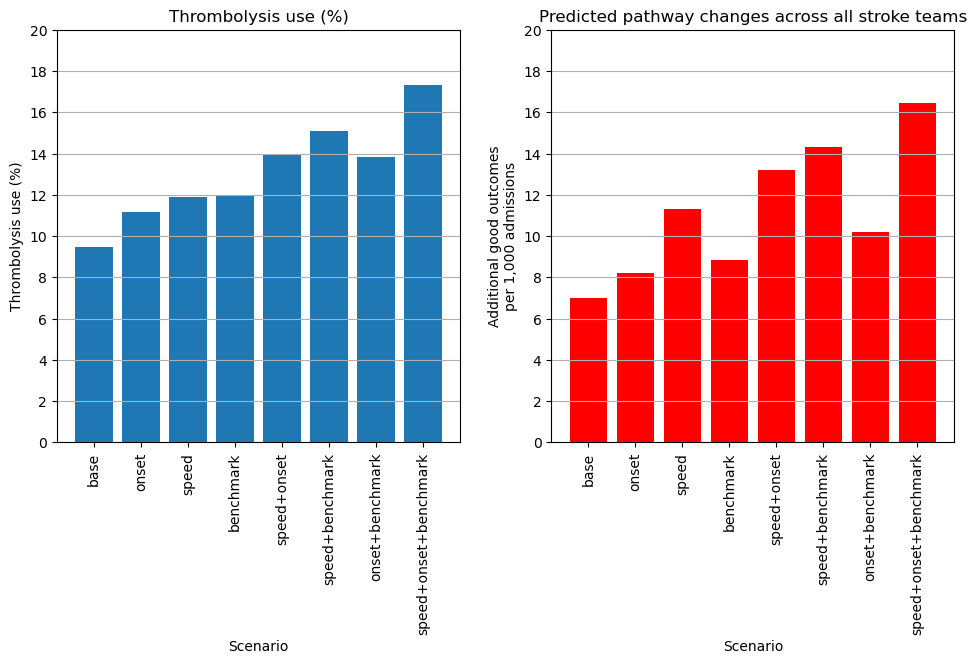

In [7]:
pathway.plot_summary_results(show=True)

### Plot results for as single stroke team

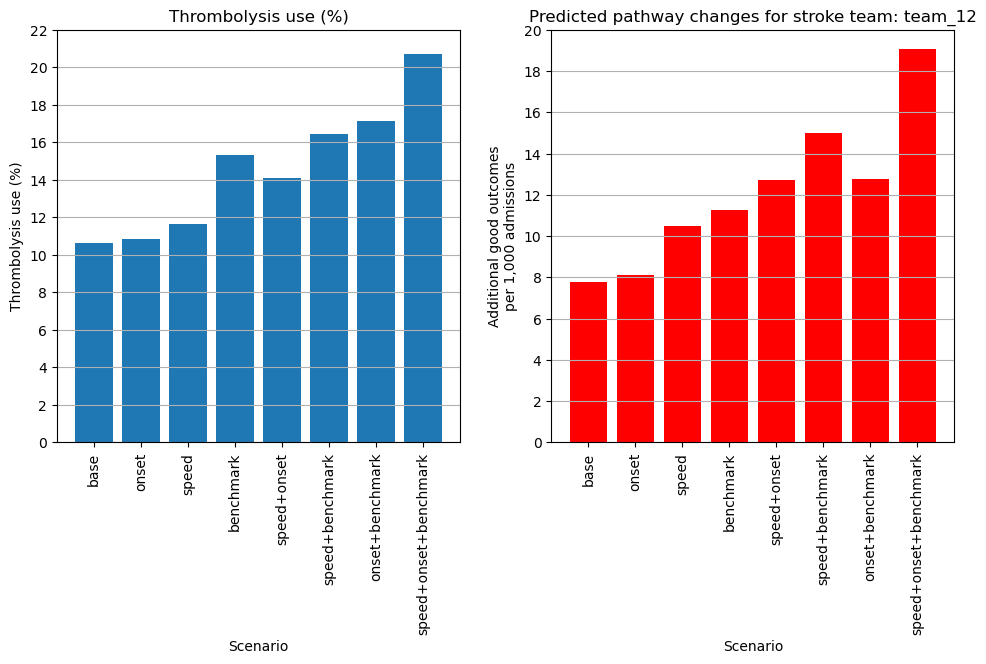

In [8]:
team = 'team_12'
pathway.plot_team_results(team, show=True)